In [1]:
import os
import sys
import time
import pickle
import string
from datetime import datetime
from datetime import timedelta
from itertools import chain, cycle
import collections
from pprint import pprint
from io import StringIO
import pathlib
import sqlite3

import numpy as np
import pandas as pd
import dask.dataframe as dd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

#import urllib
#import webbrowser
#import codecs
from bs4 import BeautifulSoup
from xml.dom import minidom
from xml.etree import ElementTree as ET
#from lxml import etree as ET #Supports xpath syntax
import xmltodict 

import nltk
import re
import Levenshtein
import networkx as nx
import json

#from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
from geopy.geocoders import Nominatim
import geopandas as gpd
import ipyleaflet
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, WMSLayer, Marker, MarkerCluster

import folium
import folium.plugins
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster


#import plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

In [2]:
df_lemmas = pd.read_pickle('./df_lemmas.pkl')

In [3]:
df_lemmas.info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 46 columns):
Bundesland               1316889 non-null object
Bundesland_idno          1316889 non-null object
Gemeinde                 1198447 non-null object
Großregion               1296722 non-null object
Großregion_idno          1225463 non-null object
Kleinregion              1286463 non-null object
Kleinregion_idno         1209145 non-null object
Ort                      1198447 non-null object
Ort_idno                 1198447 non-null object
archiv                   2416419 non-null object
bibl                     1719656 non-null object
certainty                25631 non-null object
cit_def                  461023 non-null object
cit_interp               353677 non-null object
cit_note                 111690 non-null object
cit_pRef                 79913 non-null object
cit_quote                704560 non-null object
cit_re                   113327 non-null object
cit_ref       

In [4]:
df_lemmas.columns

Index(['Bundesland', 'Bundesland_idno', 'Gemeinde', 'Großregion',
       'Großregion_idno', 'Kleinregion', 'Kleinregion_idno', 'Ort', 'Ort_idno',
       'archiv', 'bibl', 'certainty', 'cit_def', 'cit_interp', 'cit_note',
       'cit_pRef', 'cit_quote', 'cit_re', 'cit_ref', 'cit_type', 'date',
       'entry_id', 'etym', 'filename', 'fragebogenNummer',
       'hauptlemma_normalized', 'hauptlemma_orig', 'hauptlemma_unique',
       'nebenlemma_normalized', 'nebenlemma_orig', 'nebenlemma_unique',
       'note_anmerkung', 'note_diverse', 'note_notabene', 'orig_placeName',
       'paragraph', 'placeName_id', 'pos', 'quelle', 'quelleBearbeitet',
       'seite', 'simple_placeName', 'tustep', 'usg_corresp', 'verweise',
       '#form'],
      dtype='object')

In [5]:
df_lemmas.head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,placeName_id,pos,quelle,quelleBearbeitet,seite,simple_placeName,tustep,usg_corresp,verweise,#form
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,None,Subst,Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,"(diaun,)",None,None,HK 154
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,None,Subst,Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,Chur,"(diaun,)",None,None,HK 154
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,None,Subst,Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",Chur,"(diaun,)",None,None,HK 154
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,None,Interj,Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,None,"(tib,)",None,None,HK 154
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,None,Interj,Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,None,"(tib,)",None,None,HK 154


In [6]:
entry_info = ['filename', 'entry_id']

regions_info = ['Bundesland', 
                'Bundesland_idno', 
                'Gemeinde', 
                #'Gemeinde_idno',
                'Großregion', 
                'Großregion_idno', 
                'Kleinregion', 
                'Kleinregion_idno',
                'Ort', 
                'Ort_idno',
                'simple_placeName',
                'orig_placeName',
                'placeName_id', 
                'usg_corresp',]

lemmas_info = ['date',
               'hauptlemma_normalized', 
               'hauptlemma_orig', 
               'hauptlemma_unique',
               'nebenlemma_normalized',
               'nebenlemma_orig', 
               'nebenlemma_unique', 
               'tustep',
               'etym', 
               'pos',]

ref_info = ['verweise',
            'archiv',
            'quelle',
            'quelleBearbeitet', 
            'seite', 
            'fragebogenNummer', 
            'paragraph', 
            'bibl',
            '#form',]

cit_info = ['cit_def',
            'cit_interp',
            'cit_note',
            'cit_pRef',
            'cit_quote',
            'cit_re',
            'cit_ref',
            'cit_type', 
            'certainty',]

note_info = ['note_anmerkung',
             'note_diverse',
             'note_notabene',]

### Questions for the uncertaities paper

#### 1) number of entries

In [7]:
print('There are {:,} entries in the TEI/XML files'.format(len(df_lemmas)))

There are 2,416,499 entries in the TEI/XML files


#### 2) number of headwords

In [8]:
# original mainlemmas
print('There are {:,} original mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_unique.dropna())))

There are 985,853 original mainlemmas in the TEI/XML files


In [9]:
# original nebenlemma
print('There are {:,} original nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_orig.dropna())))

There are 112,309 original nebenlemma in the TEI/XML files


In [10]:
# normalized mainlemmas
print('There are {:,} normalized mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_normalized.dropna())))

There are 1,314,740 normalized mainlemmas in the TEI/XML files


In [11]:
# normalized nebenlemma
print('There are {:,} normalized nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_normalized.dropna())))

There are 112,236 normalized nebenlemma in the TEI/XML files


Number of entries without any lemma

In [12]:
no_haupt = list(set(df_lemmas.index) \
                - set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index)))

In [13]:
#Number of entries without any lemma
print('There are {:,} entries with no lemma information in the TEI/XML files'.format(len(df_lemmas.iloc[no_haupt])))

There are 115,270 entries with no lemma information in the TEI/XML files


In [14]:
df_lemmas.iloc[no_haupt][lemmas_info]

,date,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique,tustep,etym,pos
1310720,None,None,None,None,None,None,None,"(F-)asa, Fâsan, Fâsal)",None,None
1572867,None,None,None,None,None,None,None,"(ß-age, s-;egA)",None,None
1572872,None,None,None,None,None,None,None,"(sôg,)","(ahd., saga)",None
2097160,None,None,None,None,None,None,None,None,None,None
2097161,None,None,None,None,None,None,None,None,None,None
2097164,None,None,None,None,None,None,None,"(Schab,)",None,None
786448,None,None,None,None,None,None,None,None,"(Schm.II 886,823,)",None
1310737,None,None,None,None,None,None,None,"(n~adl,)",None,None
786450,None,None,None,None,None,None,None,"(Z/üi¡la,)",None,None
1310738,None,None,None,None,None,None,None,"(nei~ dl,)",None,None


Examining one of the entries with no lemmas

In [15]:
chosen = 0
df_lemmas.iloc[no_haupt][['filename', 'entry_id']].iloc[chosen]

filename    ./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml
entry_id                                  m612_qdb-d1e72628
Name: 1310720, dtype: object

In [16]:
df_lemmas.iloc[no_haupt][['filename']].iloc[0].values[chosen]

'./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml'

In [17]:
xmlfile = df_lemmas.iloc[no_haupt][['filename']].iloc[chosen].values[0]
bs = BeautifulSoup(open(xmlfile, encoding="utf8"), 'xml')
root = ET.parse(xmlfile).getroot()

In [18]:
for elem in root.iter('{http://www.tei-c.org/ns/1.0}entry'):
    if elem.attrib['{http://www.w3.org/XML/1998/namespace}id'] == df_lemmas.iloc[no_haupt][['entry_id']].iloc[chosen].values[0]:
        for description in elem.iter():
            print('field and value: ', description.tag, ' --> ', description.text)

field and value:  {http://www.tei-c.org/ns/1.0}entry  -->  
        
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}orth  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pos  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
            
field and value:  {http://www.tei-c.org/ns/1.0}gram  -->  [pl]
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  --> 

#### 3) number of entries digitised per data scientist

In [19]:
df_lemmas[ref_info].head()

,verweise,archiv,quelle,quelleBearbeitet,seite,fragebogenNummer,paragraph,bibl,#form
0,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,None,None,HK 154
1,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,None,None,None,HK 154
2,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",None,None,None,HK 154
3,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"64H6: Zurufe an Zugrinder (ho, diester, wister...",None,None,HK 154
4,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"76K70c: Zuruf an Pferde zum Rechtsgehen (hott,*)",None,None,HK 154


In [20]:
df_lemmas['archiv'].value_counts()

HK 496, k4960129.pir, korr. E.WV.                       358
HK 404, h4040803.pir, korr. E.V.                        335
HK 503, k5030312.pir, korr. E.WV.                       329
HK 383, H3831221.pla, korr. W.B.                        318
HK 407, H4070825.ned, korr. E.V.                        313
HK 374, H3741006.pla, korr. W.B.                        312
HK 373, H3731007.eck, korr. H.B.                        301
HK 372, h3720922.pir, korr. E.V.                        285
HK 503, k5030311.pir, korr. E.WV.                       284
HK 385, h3850323.pir, korr. E.V.                        276
HK 401, H4010713.ned, korr. W.B.                        272
HK 368, H3680825.pla, korr. W.B.                        269
HK 496, k4960124.pir, korr. E.WV.                       266
HK 377, h3771130.pir, korr. E.V.                        265
HK 377, h3771129.pir, korr. E.V.                        264
HK 372, h3720920.pir, korr. E.V.                        263
HK 368, H3680816.pla, korr. W.B.        

In [21]:
#https://chrisalbon.com/python/data_wrangling/pandas_regex_to_create_columns/
#https://www.rexegg.com/regex-quickstart.html

df_lemmas['#people'] = df_lemmas['archiv'].str.extract('(\.[A-ZÄÜÖa-zäüö]{3}[\^,]{0,1})', expand=True)
df_lemmas['#people'] = df_lemmas['#people'].str.lower().str.strip(string.punctuation)
df_lemmas['#people'].sort_values().value_counts()

pir    375962
kro    252937
pla    211855
sch    194301
may    150266
lei    145656
eck    132432
hof    117544
pud    101816
ned     93332
ran     91361
fue     76838
eis     72493
foe     69227
pas     52137
gro     48845
kup     45637
bar     40016
kon     34121
pue     31013
hag     24985
loi     17018
res     12091
lag     10409
gru      7464
bac      2823
keo       276
esi       130
kue        68
Name: #people, dtype: int64

In [22]:
df_lemmas[df_lemmas['#people'].isna()]['archiv'].value_counts()

HK 654, r^$                          190
HK 862, w8620922.br^$                189
HK 666, r6660221.ra^$                188
HK 715, s7150125^$                   175
HK 526, k5260920^#                   168
HK 641, r6410827ran^$                155
HK 700, s7001005^$                   153
HK 649, R6491112,PUD^$               150
HK 595, m5951209^#                   146
HK 539,                              140
HK 546, l5460305^#                   130
HK 483, k4831128^#                   130
HK 866, XYZ8661201^$                 126
HK 419, H4191207^#                   125
HK 673, s6730606^$                   112
HK 550, L5500403^#                   102
HK 825, w8251023^$                   101
HK 578, m5781103^#                    94
HK 524, k5241108^#                    77
HK 723, S7230220^$                    74
HK 542, L5420131^#                    73
HK 464, k4640628^#                    72
HK 456, k4560613                      61
HK 555, l5550318^#                    59
HK 463, k4630810

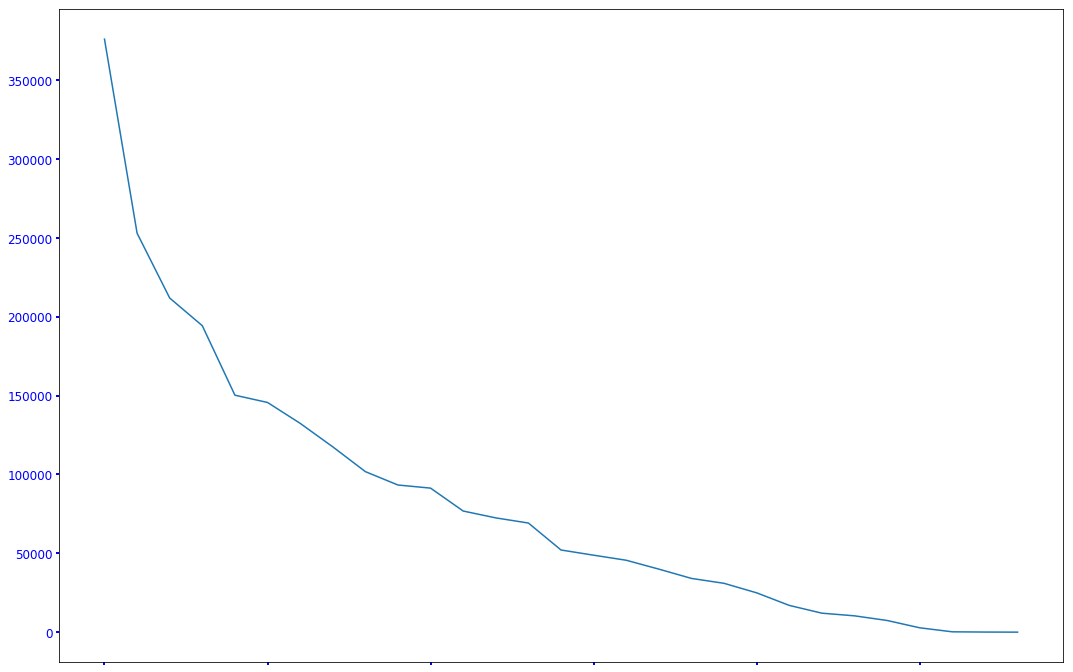

In [23]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['#people'].value_counts().plot()

In [24]:
df_lemmas[['#people',
           'hauptlemma_normalized',
           'hauptlemma_orig',
           'hauptlemma_unique',
           'nebenlemma_normalized',
           'nebenlemma_orig',
           'nebenlemma_unique',]].groupby(['#people']).count()

,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique
#people,,,,,,
bac,1166,1166,1506,133,133,225
bar,26908,26908,11717,872,872,168
eck,69456,69456,62326,4739,4739,5549
eis,38512,38512,28967,2097,2098,802
esi,23,23,88,0,0,3
foe,39013,39013,26843,1688,1688,1370
fue,44776,44776,25478,5253,5253,1831
gro,26207,26208,20254,2278,2278,1588
gru,3968,3968,3496,105,105,109


Creating the 'Drawer' field to desambiguate information of Data Scientists

In [25]:
df_lemmas['#drawer'] = df_lemmas['archiv'].str.extract('([HK]{1,2}\s+[0-9]{0,3})', expand=True)
pd.Series(df_lemmas['#drawer'].unique()).sort_values() #.value_counts()

218       HK 
4      HK 000
483    HK 120
0      HK 154
1      HK 155
2      HK 156
3      HK 157
5      HK 158
6      HK 159
7      HK 160
8      HK 161
9      HK 162
10     HK 163
11     HK 164
12     HK 165
13     HK 166
14     HK 167
15     HK 168
16     HK 169
17     HK 170
18     HK 171
19     HK 172
20     HK 173
21     HK 174
22     HK 175
23     HK 176
25     HK 177
27     HK 178
28     HK 179
29     HK 180
        ...  
702    HK 855
703    HK 856
704    HK 857
705    HK 858
706    HK 859
707    HK 860
708    HK 861
709    HK 862
710    HK 863
711    HK 864
712    HK 865
713    HK 866
714    HK 867
715    HK 868
716    HK 869
717    HK 870
718    HK 871
719    HK 873
720    HK 874
721    HK 875
722    HK 877
723    HK 878
724    HK 879
725    HK 880
726    HK 881
727    HK 882
728    HK 883
729    HK 884
730    HK 885
26        NaN
Length: 731, dtype: object

In [26]:
df_lemmas[df_lemmas['#drawer'].isna()]['archiv'].value_counts()

HK, H3950608.eck, korr. C.P.     122
381, H3811222.ned, korr. W.B.     68
HK^$                              32
HK^#                              10
502, k5020326.ran^#67              1
Name: archiv, dtype: int64

In [27]:
idx = df_lemmas[df_lemmas['archiv'] == 'HK, H3950608.eck, korr. C.P.'].index
df_lemmas.loc[idx, '#drawer'] = 'HK 395'

idx = df_lemmas[df_lemmas['archiv'] == '381, H3811222.ned, korr. W.B.'].index
df_lemmas.loc[idx, '#drawer'] = 'HK 381'

In [28]:
df_lemmas['#drawer'].value_counts()

HK 564    13760
HK 843     7548
HK 158     6252
HK 861     5972
HK 764     5760
HK 641     5596
HK 652     5568
HK 866     5559
HK 639     5541
HK 858     5518
HK 699     5459
HK 751     5454
HK 660     5424
HK 753     5405
HK 663     5382
HK 690     5348
HK 795     5336
HK 657     5325
HK 672     5319
HK 654     5299
HK 720     5279
HK 722     5276
HK 864     5224
HK 664     5205
HK 723     5198
HK 701     5138
HK 653     5124
HK 646     5115
HK 366     5092
HK 708     5065
          ...  
HK         1518
HK 302     1500
HK 757     1466
HK 452     1463
HK 465     1462
HK 299     1396
HK 424     1369
HK 227     1125
HK 409     1092
HK 435     1065
HK 212     1020
HK 251      981
HK 471      924
HK 355      917
HK 185      912
HK 206      877
HK 500      811
HK 432      621
HK 155      465
HK 436      332
HK 154       72
HK 47        55
HK 307       47
HK 156       43
HK 000        4
HK 308        4
HK 433        3
HK 221        2
HK 51         1
HK 3          1
Name: #drawer, Length: 7

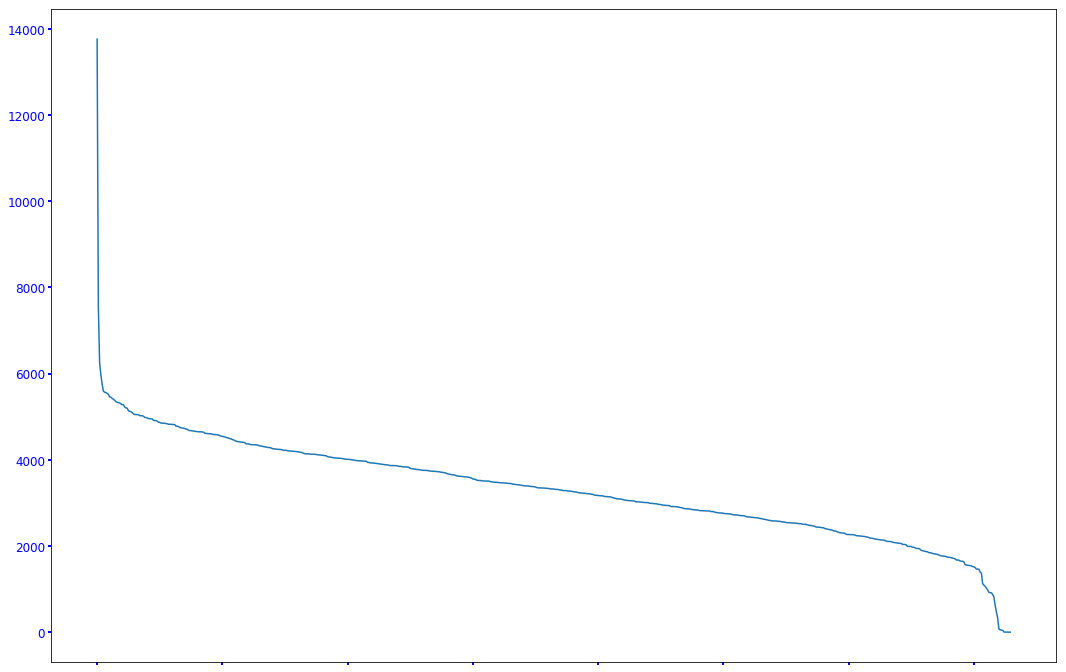

In [29]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['#drawer'].value_counts().plot()

#### 4) number of headwords per letter

In [30]:
headwords_idx = set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index))

In [31]:
headwords_list = []

for idx in headwords_idx:
    if df_lemmas.hauptlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_unique.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_orig.iloc[idx])
        
first_letter = [x[0].upper() for x in headwords_list]

In [32]:
freq_letters = nltk.FreqDist(first_letter)

freq_letters.pop('(')
freq_letters.pop(' ')
freq_letters.pop('←')
freq_letters.pop('[')
freq_letters.pop(':')
freq_letters.pop('^')
freq_letters.pop('?')
freq_letters.pop('1')
freq_letters.pop('2')
freq_letters.pop('6')
freq_letters.pop('─')
freq_letters.pop('†')
freq_letters.pop('~')
freq_letters.pop('|')
freq_letters.pop('\xa0')

freq_letters.most_common(50)

[('S', 373210),
 ('G', 192629),
 ('F', 190978),
 ('H', 189854),
 ('K', 180359),
 ('A', 162978),
 ('W', 122670),
 ('M', 107322),
 ('R', 104967),
 ('L', 101267),
 ('P', 90019),
 ('Z', 85329),
 ('T', 74090),
 ('E', 71092),
 ('D', 61183),
 ('N', 54603),
 ('U', 33973),
 ('J', 21494),
 ('O', 21345),
 ('B', 13719),
 ('Ü', 11380),
 ('I', 9663),
 ('Ë', 7563),
 ('Ê', 5051),
 ('Ô', 3280),
 ('Q', 2768),
 ('Ö', 2668),
 ('Â', 1275),
 ('Ä', 1132),
 ('V', 324),
 ('C', 98),
 ('Û', 82),
 ('X', 62),
 ('Y', 34),
 ('Á', 14),
 ('Å', 9),
 ('Ú', 3),
 ('!', 3),
 ('SS', 3),
 ('Ó', 2),
 ('9', 2),
 ('É', 1),
 ('Î', 1),
 ('+', 1),
 ('Ǎ', 1),
 ('Ē', 1),
 ('5', 1),
 ('*', 1),
 ('¹', 1),
 ('Í', 1)]

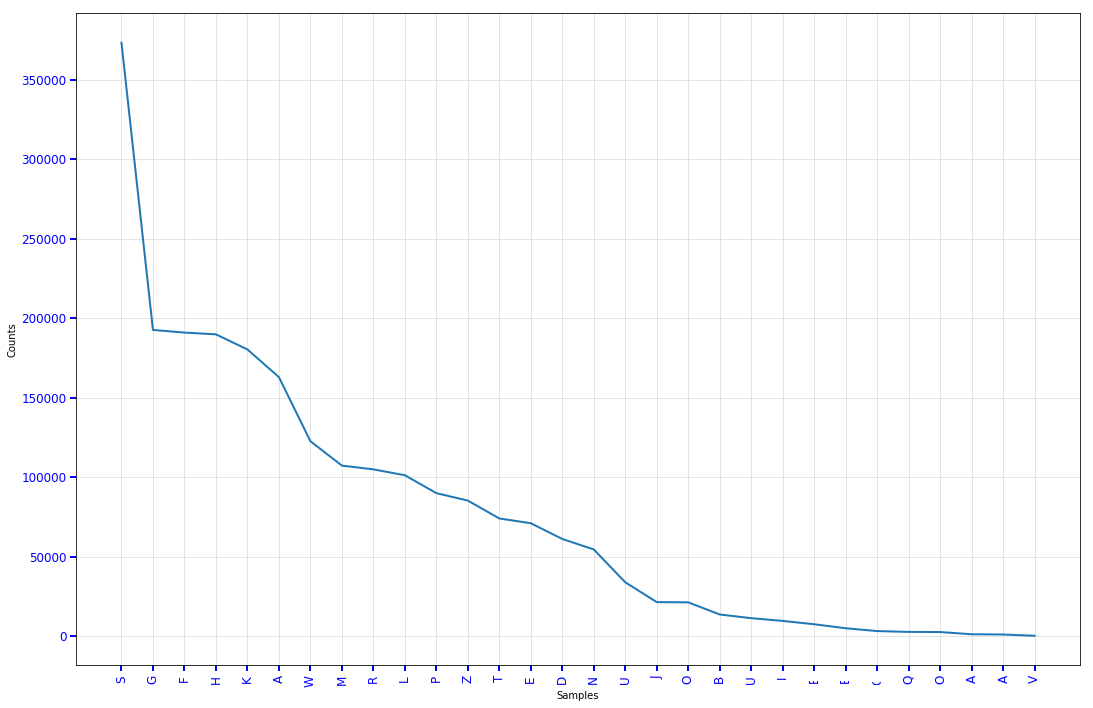

In [33]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=6, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
freq_letters.plot(30,cumulative=False,)

#### 5) number of headwords per location

In [34]:
print(len(set(df_lemmas.Bundesland.dropna().index)))
print(len(set(df_lemmas.Ort.dropna().index)))
print(len(set(df_lemmas.Bundesland.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))))

1316889
1198447
1198447


there is no intersection between records with simple placenames and records with original placenames

In [35]:
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index))

set()

and there is no intersection between records with simple placenames and records with Ort information

In [38]:
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

In [63]:
locations_idx = set(df_lemmas.simple_placeName.dropna().index)\
.union(set(df_lemmas.Ort.dropna().index))\
.union(df_lemmas.orig_placeName.dropna().index)

In [64]:
locations_list = []

for idx in locations_idx:
    if df_lemmas.simple_placeName.iloc[idx]:
        locations_list.append(df_lemmas.simple_placeName.iloc[idx])
    elif df_lemmas.Ort.iloc[idx]:
        locations_list.append(df_lemmas.Ort.iloc[idx])
    elif df_lemmas.orig_placeName.iloc[idx]:
        locations_list.append(df_lemmas.orig_placeName.iloc[idx])

In [65]:
freq_locations = nltk.FreqDist(locations_list)
freq_locations.most_common(50)

[('Wien', 71263),
 ('Mühlheim am Inn', 34694),
 ('(Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW', 33278),
 ('Gmunden', 33056),
 ('Kautzen', 32858),
 ('Kufstein', 21403),
 ('Linz', 21282),
 ('Plattetschl. BöW', 20835),
 ('Thiersee $Tiersee$', 20598),
 ('Poysdorf', 19641),
 ('Rangersdorf', 16430),
 ('Stainz', 16174),
 ('(Umg./Bz.) Braunau OÖ', 15722),
 ('Traun', 15627),
 ('Dunkelsteinerwald', 15541),
 ('Hohenfurth SBö.', 15374),
 ('Königswerth Egerld.', 14392),
 ('Fusch an der Großglocknerstraße', 13364),
 ('Puchberg am Schneeberg', 12969),
 ('Obermösel in Gm. Mösel Gott.(Slow.)', 12555),
 ('Pottendorf', 12501),
 ('Fendels', 11318),
 ('Kleinlobming', 11088),
 ('Sonnbg. SBö.', 10836),
 ('Straßburg', 10781),
 ('Ulrichsberg', 10609),
 ('Tullnitz SMä.', 10286),
 ('Rohr im Gebirge', 10276),
 ('Herzogenburg', 10084),
 ('Imst', 9854),
 ('Pilgersdorf', 9769),
 ('Gr.Tajax SMä.', 9579),
 ('Kumrowitz Brünn (Tschech.)', 9416),
 ('St. Gilgen', 9103),
 ('Hollabrunn', 8843),
 ('Gr.Arlt. in Sa.', 8769),

#### 6) average number of entries per headword

In [42]:
freq_words = nltk.FreqDist(headwords_list)
freq_words.most_common(50)

[('gên', 9039),
 ('kemmen', 5883),
 ('Hand', 5088),
 ('Haut', 4253),
 ('Kopf', 3931),
 ('Leib', 3790),
 ('Zand', 3671),
 ('sein', 3283),
 ('sehen', 3267),
 ('lich', 3200),
 ('tuon', 3131),
 ('rôt', 2773),
 ('klein', 2636),
 ('halten', 2617),
 ('Hâr', 2573),
 ('Nase', 2375),
 ('schwarz', 2308),
 ('ziehen', 2261),
 ('Hôhzeit', 2230),
 ('haben', 2208),
 ('schlagen', 2190),
 ('faren', 2171),
 ('machen', 2023),
 ('können', 2012),
 ('Mann', 1987),
 ('ein', 1975),
 ('lâßen', 1960),
 ('Maul', 1952),
 ('schwellen', 1945),
 ('guot', 1941),
 ('gëben', 1924),
 ('Georg', 1902),
 ('schön', 1878),
 ('Ort', 1859),
 ('Stein', 1847),
 ('schneiden', 1825),
 ('Fleisch', 1796),
 ('kurz', 1749),
 ('ër', 1736),
 ('Kind', 1732),
 ('helfen', 1687),
 ('Haus', 1685),
 ('schwär', 1683),
 ('Finger', 1672),
 ('ê', 1652),
 ('lang', 1628),
 ('schauen', 1613),
 ('grôß', 1608),
 ('Schneider', 1597),
 ('weiß', 1581)]

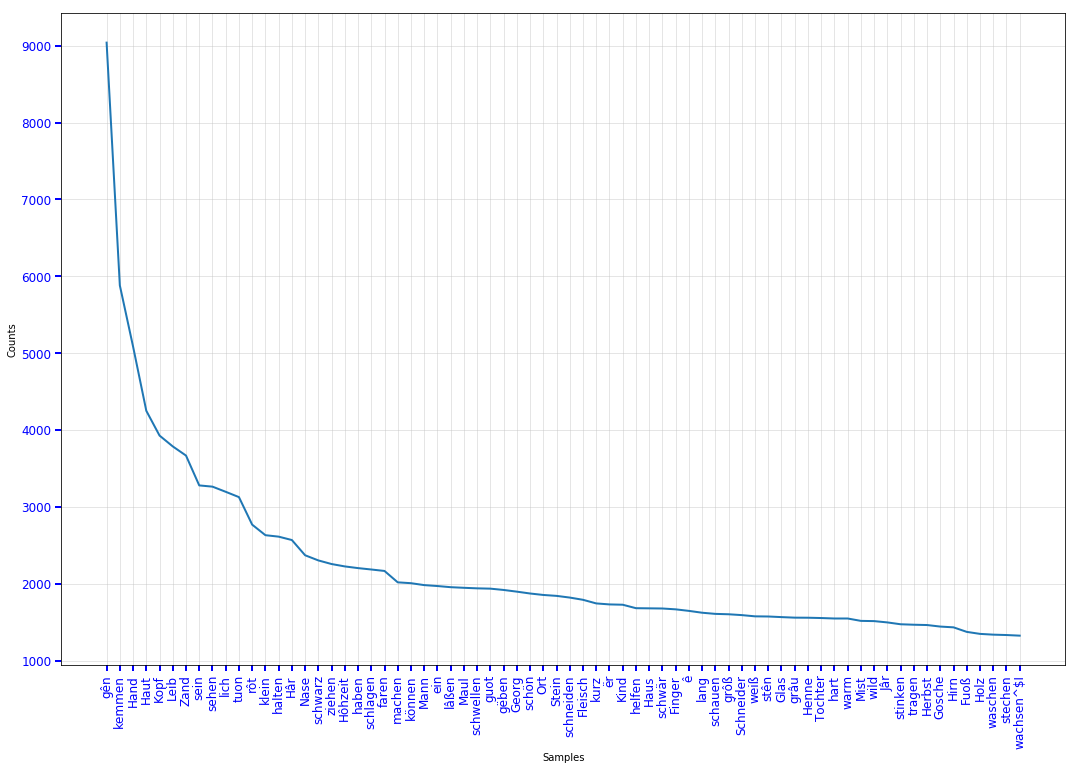

In [43]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_words.plot(70,cumulative=False,)

In [45]:
len(headwords_list)/len(freq_words)

9.61762763716607

#### 7) number of different definitions / meanings

#### 8) number of locations cited

In [46]:
len(freq_locations)

26396

In [47]:
for col in regions_info:
    print(col, '--->', len(df_lemmas[col].unique()))

Bundesland ---> 10
Bundesland_idno ---> 10
Gemeinde ---> 1147
Großregion ---> 33
Großregion_idno ---> 32
Kleinregion ---> 324
Kleinregion_idno ---> 322
Ort ---> 1146
Ort_idno ---> 1147
simple_placeName ---> 25494
orig_placeName ---> 4437
placeName_id ---> 1308
usg_corresp ---> 21


In [48]:
#fine grained locations --> Ort + simple placename + original placename
len(set(df_lemmas.Ort).union(set(df_lemmas.simple_placeName)).union(df_lemmas.orig_placeName))

30231

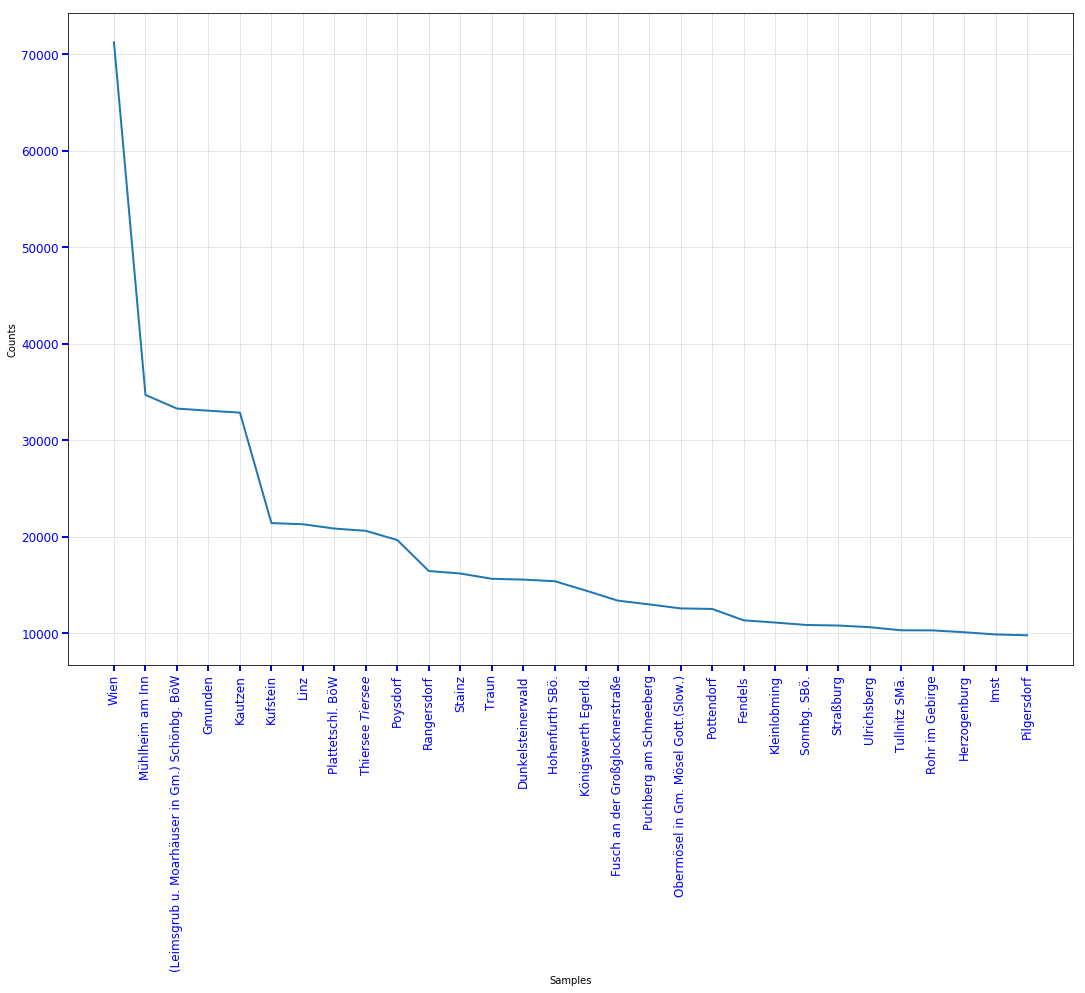

In [49]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_locations.plot(30,cumulative=False,)

#### 9) number of sources cited

#### 10) number of different people cited

#### 11) number of headwords per person

#### 12) number of entries per person

#### 13) number of concepts per questionnaire

#### 14) number of headwords related to questionnaire

In [50]:
df_lemmas.fragebogenNummer.value_counts()

23I6b: Haut m. Adj., Syn. (behaart/Pelz, gelbl.,*); Zshg. Hautfarbe-Haarfarbe/Charakter?                     2707
1A20: Kopf/Schädel als Gw. (Weiberkopf)                                                                      2382
1A3: Kopf/Haupt (übertr.) in Vergl./Ra.                                                                      2286
21C8: Fleisch best.Lebewesen (Heiden-*, Hirsch-,*)                                                           2262
1E12: Backenstreich/Ohrfeige; leicht/stark/schallend                                                         2047
20B2: Blut m. Vb. (es rinnt/hämmert; B. verlieren,*)                                                         2013
43A54b: kommen m. Ziel-/Ortsang. (aus d.Sinn k.,*)                                                           1982
1H1: Mund/Maul; Füg./Ra.                                                                                     1956
42A13d: gehn m. Ziel-/Ortsang. (fortg.; aufs Land g.;*)                                 

In [51]:
idx1 = set(df_lemmas['fragebogenNummer'].dropna()[df_lemmas['fragebogenNummer'].dropna().str.contains("EFb")].index)

In [52]:
len(df_lemmas['fragebogenNummer'][idx1])

156043

In [53]:
idx2 = set(df_lemmas['fragebogenNummer'].dropna()[df_lemmas['fragebogenNummer'].dropna().str.contains("MüWi")].index)

In [54]:
len(df_lemmas['fragebogenNummer'][idx2])

755

In [55]:
idx3 = set(df_lemmas['fragebogenNummer'].dropna().index)

In [56]:
idx3 = idx3 - idx1
idx3 = idx3 - idx2

In [57]:
len(df_lemmas['fragebogenNummer'][idx3])

1140338

In [60]:
df_lemmas['#fragebogen'] = None
df_lemmas.loc[idx1,'#fragebogen'] = 'Additional'
df_lemmas.loc[idx2,'#fragebogen'] = 'Geographic'
df_lemmas.loc[idx3,'#fragebogen'] = 'Systematic'

In [ ]:
df_lemmas['#bestlemma'] = None
for idx in df_lemmas.index:
    if df_lemmas.hauptlemma_normalized.iloc[idx]:
        df_lemmas['#bestlemma'] = df_lemmas.hauptlemma_normalized.iloc[idx]
    elif df_lemmas.hauptlemma_unique.iloc[idx]:
        df_lemmas['#bestlemma'] =  df_lemmas.hauptlemma_unique.iloc[idx]
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        df_lemmas['#bestlemma'] = df_lemmas.hauptlemma_orig.iloc[idx]
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        df_lemmas['#bestlemma'] = df_lemmas.nebenlemma_normalized.iloc[idx]
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        df_lemmas['#bestlemma'] =  df_lemmas.nebenlemma_orig.iloc[idx]
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        df_lemmas['#bestlemma'] = df_lemmas.nebenlemma_unique.iloc[idx]

In [ ]:
df_lemmas[['#fragebogen','#bestlemma',]].groupby(['#fragebogen','#bestlemma']).count()

#### 15) number of headwords related to questions

#### 16) number of entries related to questions related to authors of questions/questionnaires

#### 17) number of headwords related to questions related to authors of questions/questionnaires

#### 18) number of locations per person (that is identified)

In [ ]:
df_lemmas['#location'] = None
for idx in df_lemmas.index:
    if df_lemmas.simple_placeName.iloc[idx]:
        df_lemmas['#location'] = df_lemmas.simple_placeName.iloc[idx]
    elif df_lemmas.Ort.iloc[idx]:
        df_lemmas['#location'] =  df_lemmas.Ort.iloc[idx]
    elif df_lemmas.orig_placeName.iloc[idx]:
        df_lemmas['#location'] = df_lemmas.orig_placeName.iloc[idx]

#### 19) number of female:male collectors

#### 20) average number of entries per questions

#### 21) number of entries related to questionnaires

In [59]:
df_lemmas['#fragebogen'].value_counts()

Systematic    1140338
Additional     156043
Geographic        755
Name: #fragebogen, dtype: int64

#### 22) number of entries related to historical sources

#### 23) number of entries related to historical poetic sources

#### 24) number of entries related to "free collections"

#### 25) number of people working on the collection since the start

#### 26) names of people working on the collection since the start

#### 27) number of collectors per questionnaire

#### 28) average number of definitions per entry / paper slip

#### 29) average number of entries per person

#### 30) average number of headwords per person

#### 31) average number of entries per type of location

In [166]:
df_lemmas[regions_info].info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 13 columns):
Bundesland          1316889 non-null object
Bundesland_idno     1316889 non-null object
Gemeinde            1198447 non-null object
Großregion          1296722 non-null object
Großregion_idno     1225463 non-null object
Kleinregion         1286463 non-null object
Kleinregion_idno    1209145 non-null object
Ort                 1198447 non-null object
Ort_idno            1198447 non-null object
simple_placeName    395816 non-null object
orig_placeName      1334384 non-null object
placeName_id        1316887 non-null object
usg_corresp         16675 non-null object
dtypes: object(13)
memory usage: 1.3 GB


In [181]:
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

#### number of entries with time information

In [63]:
for year in df_lemmas.date.unique():
    print(year)

None
16.Jh.
1730
1363
1405
15.u.16.Jh.
17.Jh.
1549
Anf.15.Jh.
1399
Mitte 15.Jh.
vor 1483
1266
1431
1387
1392
1401
1495
15./16.Jh.
Mitte 16.Jh.
1705
1585
1513
O 1387
1759
1734
O 1642
1778
1623
1560-1594
2.Hä.16.Jh.
um 1600
1500
1607
1588
1587
1754
1597
1667
1507
1574
15.Jh.
1572
1745
1578
1380
O 1394
1512
15.6. 1575
1621
1467
1590
1492
1434
1732
1493-1523
1699
1648-1658
1.Hä.18.Jh.
1342
1297
1441
1515
1550
1772
O 1563
Mitte d.15.Jh.
1679
18.Jh.
1581
1376
1629
1630
C kais.Komm. 1607
1623; 1699
16.-18.Jh.
1608; 1651 [?]
1682
1715
4.2.1308
a. 1494
1701
1418-1454
a. 1580
1345
1290
1460
16. jh.
1465
a. 1426
1354
1509
1532
1463
1477
18. jh.
14.6.1621
1258
17. jh.
1564
a. 1431
19. 4. 1575
1284
1291
1375
1372
1323
1563
[24.3.] 1568
1188-93, C 13. Jh.
1521
1648
a. 1582
15. jh.
a. 1613
a. 1520
a. 1484
1668
1573
a. 1528
Mitte 16. Jh.
17.jh.
16.jh.
1436
14. Jh.
1427
vor 1621
a. 1565
1583
a. 1726
1. H. 16. Jh.
1. Hä. 16. Jh.
Jänner 1951
1494
vor 1511?
6.8.1592
1523
1581-95
1555-90
20.6.1567
1337
177

15781578
1224
1632 27/4
1751-1764
O 1473O 1474
C ? ca.1627
31.8.1755
30.8.1630
O 27.11.1499
13.9.1927
a.1460 (undatiert)
(Mitte 16. Jh.)
29. 10. 1677
2. 9. 1400
1927Kröte
1. Dezem. d. 15. Jhds.
1619
O 1340-1350
ac. 1474
(4.1.) 1434
19.2.1983
18.2.1982
27.6.1981
7.11.1981
18.12.1881
1555-97
a 1490
a 1482
a 1419
a 1436
6/7 1580
(1701)
O 1344
c.1589
5.12.1911
O 1480,1515,1517
1755 28/10
8.7.1927
19301951
1.11.1926
30.X.1926
4.7.27
20.7.1340
C 1397
16.12.1926
1576-99
1733
5.12.1913
11.9.58
1.8.1561
19.2.1385
19.12.27
Konz. 1452
Ausgabs..
Orig.aus 1393
19051912
18871912
C1638
O1588
21.7.64
13.12.1928
1923 Dalla Torre 4,2
1149
1260 (1261)
1261
1262
1306 (1306) (1307)
1365 (1376)
1342,1349,1355,1378
1382,1384,1384,1400,1468
1453,1493
12.7.1933
15 Jh.
14. 4. 1288
ca. 1918
1353 [Überlieferg. von 1511]
23.5.1929
November 1950
2.4.36
15. Jt.
Juni 1958
3. 7. 27
14.12.26
(1560-94)
Juni 1980
7.3.1923
849 kop. 13. Jh. 2. Hälfte
21.1.42
30.3.1919
Lung., Egerl., sbair.
14.1.1588
141
ac
Orig. aus 1354
1

11.-15.Jh.
13. u. 14.Jh.
14.8.1573
Anf.18.Jh.
2. Hä 16. Jh
15./16. Jh
30.1.1558
1870 ff.
ungef. 1420
seit dem 9. Jh.
14. 4. 1768
bis 1960
ad 1580
O. 1508
C. 1525
O. 1509
C. 1552
O. 8. 8. 1670
O. ? 1534
14.12.20
1.11.1929
15.Jht.
6.3.25
Mitte 15.Jhd.
2.H. 16.jh.
1578-1597
1582-1599
1582-1591
1555-1533
14.Jht.
O. 1468
O. 1432
C 1477
O. 1755
O. 1760
2. 9. 1304
Riegerschlag
Blauenschlag
Tieberschlag
Oberbaumgarten
O 1276
17. 10. 1578
letztes Dezennium d. 15. Jh.
29. 8. 1572
o. J.
19.9.1582
17. u. 18.Jh.
1050
12.Jh. - vor 1140
[2. Febr.] 1782
1920-1928
Konzpt 1644
vor 100 Jahren
ad 1398
20.2.1391
August 1950
C. ca. 1500 > ca. 1420
5.8.1574
7.VII.1550
im 17. u. 18. Jh.
1492 u. öfter
7.11.1578
erst um Jhdt.wende üblich
27.6.34
1555-80
1551-95
aus 1377
1578-91
23. 4. 1371
Ende des 16.Jh.
Orig. aus 1387
Orig. 1313
[seiner [Popowitschs] Zeit]
1405-1523
29. 9. 1313
1418-1464
seit dem Jahre 1914
1830-1860
9. 6. 1335
O. 1412
[vor Januar 8] 1574
1555-
11.3.1575
1712-1751
19.12.1661
5.5.1563
11.2.161

In [110]:
df_lemmas.date.value_counts()

17.Jh.              738
16.Jh.              707
1587                634
1623                631
15.Jh.              567
16. Jh.             498
1550                486
17. Jh.             486
1581                462
1532                455
1969                431
1463                400
1368                388
15. Jh.             377
1498                345
1465                329
1553                319
1367                311
1454                304
1590                304
1573                302
1467                292
1494                291
1365                287
1460                274
1621                262
1624                260
1370                257
1514                256
1699                254
                   ... 
Nachkriegszeit        1
12.2.1928             1
(O 1352) 51           1
9.Jh.                 1
1229                  1
ca. 1540              1
K 1477                1
25. 8. 13             1
1950,                 1
15.3. 1596            1
1025            

In [114]:
df_lemmas['#year'] = df_lemmas['date'].str.extract('([0-9]{4})', expand=True)
df_lemmas['#year'].sort_values().value_counts()

1587    653
1623    641
1550    533
1581    480
1532    473
1648    443
1969    434
1463    409
1368    394
1590    374
1465    371
1460    366
1553    365
1498    349
1621    335
1454    318
1367    315
1418    314
1573    312
1467    306
1494    302
1365    289
1400    287
1624    279
1560    272
1361    265
1370    260
1514    258
1513    258
1699    257
       ... 
1073      1
1174      1
1098      1
1223      1
1010      1
1239      1
2003      1
1039      1
1088      1
1261      1
2129      1
1149      1
1871      1
1113      1
1069      1
1998      1
1230      1
1012      1
2008      1
1177      1
1059      1
9541      1
1085      1
1187      1
1185      1
1808      1
0147      1
1141      1
1198      1
1827      1
Name: #year, Length: 865, dtype: int64

In [108]:
df_lemmas['#year'] = df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)
df_lemmas['#year'].sort_values().value_counts()

16.Jh.     1051
16. Jh.     794
17.Jh.      783
15.Jh.      645
17. Jh.     521
15. Jh.     422
18.Jh.      266
17.jh.      239
16. jh.     224
16.jh.      210
17. jh.     202
18. Jh.     199
15. jh.     169
15.jh.      153
14.Jh.      105
14. Jh.     102
16.Jh        78
18.jh.       62
16. Jh       58
15.Jh        56
18. jh.      49
17.Jh        48
15. Jh       44
17. Jh       39
14. Jh       31
18.Jh        25
14.Jh        25
18. Jh       24
16 Jh.       18
17 Jh.       16
           ... 
11.Jh.        2
17.JH.        2
15.jh         2
12. Jh.       2
18.jh         2
18 Jh.        2
17.jh         2
13.Jh         2
17 Jh         2
15. jh        2
14 Jh.        2
19.Jh         2
11. Jh.       1
13.jh.        1
14. Hh        1
16.jh         1
18 Jh         1
10 Jh.        1
12 Jh         1
14. jh        1
12.Jh         1
18 JH         1
15 .Jh.       1
16 jh.        1
10.Jh.        1
16. JH.       1
18. jh        1
13. Jh        1
18 jh         1
19.jh.        1
Name: #year, Length: 78,

In [65]:
df_lemmas[df_lemmas['#year'].isna()]['date'].value_counts()

17.Jh.                     738
16.Jh.                     707
15.Jh.                     567
16. Jh.                    498
17. Jh.                    486
15. Jh.                    377
17.jh.                     237
16. jh.                    214
17. jh.                    201
16.jh.                     195
15. jh.                    166
15.jh.                     152
18.Jh.                     152
18. Jh.                    106
Mitte 16.Jh.                98
14.Jh.                      94
14. Jh.                     90
Mitte 16. Jh.               87
18.jh.                      56
2.Hä.16.Jh.                 47
18. jh.                     42
2. Hälfte 16. Jh.           41
16.Jhdt.                    41
1. Hä. 16. Jh.              37
1. Hälfte 18. Jh.           36
1.Hä.16.Jh.                 33
2. Hä. 16. Jh.              29
2. H. 16. Jh.               27
Mitte 18.Jh.                27
\n                          26
                          ... 
vor Jahren                   1
1 Dezen.

In [78]:
df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)[0].unique()

array([nan, '16.Jh.', '17.Jh.', '15.Jh.', '18.Jh.', '16. jh.', '18. jh.',
       '17. jh.', '13. Jh.', '15. jh.', '16. Jh.', '17.jh.', '16.jh.',
       '14. Jh.', '14.Jh', '13.Jh.', '15.jh.', '15. Jh.', '14.Jh.',
       '15. Jh', '17. Jh.', '18. Jh', '14. jh.', '18. Jh.', '15.Jh',
       '18.Jh', '16.Jh', '17 jh.', '18.jh.', '17.Jh', '14.jh.', '18 jh.',
       '16. Jh', '19.Jh.', '12.Jh.', '19.jh.', '17 Jh.', '14. Jh',
       '16 Jh', '17. Jh', '15 Jh', '17.JH.', '16 Jh.', '11.Jh.', '18 Jh.',
       '18 JH', '18 Jh', '19. Jh.', '15 Jh.', '16. JH.', '14. Hh',
       '17.jh', '15. jh', '19.Jh', '18.jh', '12 Jh', '15 jh.', '13.Jh',
       '10 Jh.', '12. Jh.', '10. Jh.', '19. Jh', '16 jh.', '13.jh.',
       '15.jh', '12.Jh', '10.Jh.', '15 jh', '16. jh', '17 jh', '14. jh',
       '18 jh', '17 Jh', '14 Jh.', '18. jh', '13. Jh', '15 .Jh.', '16.jh',
       '11. Jh.'], dtype=object)

In [29]:
len(df_lemmas) - len(locations_idx)

686299

In [223]:
df_lemmas.to_pickle('./df_lemmas.pkl')